In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from ipywidgets import widgets, Box, Layout, TwoByTwoLayout
from IPython.display import display, clear_output, HTML

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

# Global Variables
web_traffic_df = pd.read_csv('../assets/GA_web_traffic_data_12_08_20.csv')
y_metrics = ['Sessions', 'Page Views']
key_metrics = ['Users', 'Page Views', 'Sessions']
segments = ['All Users', 'New Users', 'Returning Users']

class LinearModelController():
    """
    Derives dictionary needed for the LinearModelView
    Linear regression models are produced for Users vs each of the self.y_metrics, 
    as well as data frames with x and y datapoints.
    """
    
    def __init__(self, web_traffic_df, y_metrics):
        """
        :params web_traffic_df: Refers to the google analytics web traffic dataframe read from file
        :params y_metrics: metrics to be represented on y axis against users in linear regression
        """
        self.df = web_traffic_df.copy()
        self.y_metrics = y_metrics
        
    def execute(self):
        all_and_new_users_df = self.get_all_and_new_users_only_df()
        return self.get_linear_model_dicts_for_y_metrics(all_and_new_users_df)

    def get_all_and_new_users_only_df(self):
        """
        Get copy of original dataframe which excludes the Returning Users
        segment and meets linear model prerequisites to a greater extent 
        """
        all_and_new_users_df = self.df[self.df['Segment']!='Returning Users'].copy()
        all_and_new_users_df.drop(['Month of Year', 'Date Range', 'Segment'], axis=1, inplace=True)
        return all_and_new_users_df
    
    def get_linear_model_dict(self, all_and_new_users_df, y_metric):
        """
        Linear model dictionary provides the linear model object and 
        also model training points for x and y
        For demo purposes, test_size and random_state are set to defaults
        """
        lm = LinearRegression()
        X_train, X_test, y_train, y_test = train_test_split(all_and_new_users_df[['Users']], all_and_new_users_df[[y_metric]], 
                                                            test_size=0.4, random_state=101)
        lm.fit(X_train, y_train)
        lm_data_points_df = pd.concat([X_train, y_train], axis=1, join='inner')
        
        lm_dict = {"linear model":lm, "linear model data points df": lm_data_points_df}
        return lm_dict
    
    def get_linear_model_dicts_for_y_metrics(self, all_and_new_users_df):
        """
        Provides dictionary with a linear model and linear model data points 
        in a dataframe for Users vs Sessions and Users vs Page Views.
        From the executable dictionary:
            - Access the desired linear model e.g. for Sessions with:
                linear_model_dicts['Sessions']['linear model']
            - Access the Sessions linear model data points with:
                linear_model_dicts['Sessions']['linear model data points df']
        """
        lm_dict_by_y_metric = {self.y_metrics[0]:0, self.y_metrics[1]:0}
        for y_metric in self.y_metrics:
            lm_dict = self.get_linear_model_dict(all_and_new_users_df, y_metric)
            lm_dict_by_y_metric[y_metric] = lm_dict
        return lm_dict_by_y_metric
    
class LinearModelView():
    """
    Provides GUI with graph to represent linear model 
    with training points for x and y values. x axis refers to Users 
    whereas y axis is dependent on the y metric selected from a dropdown 
    'selector' box
    """
    
    def __init__(self, lm_dict_by_y_metric, y_metrics):
        """
        :params lm_dict_by_y_metric: Linear model dictionary with linear model
                                    and a linear model data points dataframe for 
                                    Users vs each of the y_metrics. 
                                    Dictionary is derived from LinearModelController
        :params y_metrics: metrics to be represented on y axis against users in
                           linear regression
        """
        self.lm_dict_by_y_metric = lm_dict_by_y_metric
        self.y_metrics = y_metrics
        
    def execute(self):
        self.y_metric_selector = self.get_y_metric_selector()
        self.display_y_metric_selector_box()
        lm_data_points_df = self.lm_dict_by_y_metric[self.y_metrics[0]]['linear model data points df']
        self.render_regression_plot(self.y_metrics[0], lm_data_points_df)
        # The y_metric_selector is set up to 'observe' the change in the y_metric
        self.y_metric_selector.observe(self.change_y_metric, names='value')
        
    def get_y_metric_selector(self):
        y_metric_selector = widgets.Dropdown(options=self.y_metrics,
                                             value=self.y_metrics[0],
                                             disabled=False)
        return y_metric_selector
        
    def display_y_metric_selector_box(self):
        box = Box(children=[widgets.Label('Please select y metric:'), self.y_metric_selector])
        display(box)
    
    def render_regression_plot(self, y_metric, lm_data_points_df):
        fig = plt.figure(figsize=(10, 6))
        ax1 = plt.subplot()
        sns.regplot(x="Users", y=y_metric, data=lm_data_points_df, ax=ax1)
        
    def change_y_metric(self, change):
        """
        Upon changing the y_metric in the dropdown,
        the self.y_metric_selector value is passed to self.lm_dict_by_y_metric
        to get data points required to render the regression plot.
        """
        clear_output()
        lm_data_points_df = self.lm_dict_by_y_metric[self.y_metric_selector.value]['linear model data points df']
        self.render_regression_plot(self.y_metric_selector.value, lm_data_points_df)
        self.display_y_metric_selector_box()

In [2]:
class LinearModelPredictorView():
    """
    Provides GUI with option for user to enter a number of users in
    order to predict the number of Sessions and Page Views, based on
    2 linear models
    """
    def __init__(self, lm_dict_by_y_metric, y_metrics):
        """
        :params lm_dict_by_y_metric: Linear model dictionary with linear model
                                    and a linear model data points dataframe for 
                                    Users vs each of the y_metrics. 
                                    Dictionary is derived from LinearModelController
        :params y_metrics: metrics to be represented on y axis against users in
                           linear regression
        """
        self.lm_dict_by_y_metric = lm_dict_by_y_metric
        self.y_metrics = y_metrics
        
    def execute(self):
        self.set_up_widgets()
        self.button.on_click(self.predict_y_values)
    
    def set_up_widgets(self):
        title_label = widgets.Label('Predict Sessions and Page Views for All Users:')
        title_label.add_class('widgetTitle')
        label_names = ['Enter Number of Users:','','']
        self.label_widgets = [widgets.Label(label_name) for label_name in label_names]
        self.get_users = widgets.Text()
        users_box = Box(children=[self.label_widgets[0], self.get_users])
        self.output = widgets.Output()
        self.button = widgets.Button(description="Submit")
        
        display(title_label)
        display(users_box)
        display(self.button, self.output)
        
    def predict_y_values(self, b):
        """
        On click of button this func is executed.
        The number of Users from the value assigned to the self.get_users 
        text widget is passed as an integer to a numpy array.
        Thereafter predictions are made for the y metrics which are displayed 
        in a label widgets to the end user
        """
        self.label_widgets
        with self.output:
            users = pd.DataFrame(np.array([int(self.get_users.value)]), columns= ['Users'])
            i = 1
            for y_metric in self.y_metrics:
                self.get_y_value(y_metric, users, i)
                i +=1
        return self.label_widgets
                
    def get_y_value(self, y_metric, users, i):
        """
        The linear model object (lm) is obtained for Users vs the y_metric.
        A prediction for the y_metric is assigned to the label widget
        """
        lm = self.lm_dict_by_y_metric[y_metric]['linear model']
        prediction = int(lm.predict(users)[0][0])
        self.label_widgets[i].value = "{}: {}".format(y_metric, prediction)
        display(self.label_widgets[i])

In [3]:
linear_model_controller = LinearModelController(web_traffic_df, y_metrics)
linear_model_dicts = linear_model_controller.execute()

# Web Traffic Data Exploration | with Linear Regression Analysis

## Part 4: Web Traffic Dashboard on Kaggle

## Section A: Linear Regression Model

Box(children=(Label(value='Please select y metric:'), Dropdown(options=('Sessions', 'Page Views'), value='Sess…

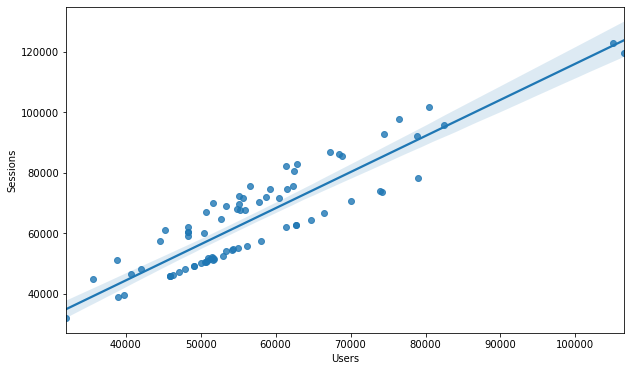

In [4]:
linear_model_view = LinearModelView(linear_model_dicts, y_metrics)
linear_model_view.execute()

In [5]:
linear_model_predictor_view = LinearModelPredictorView(linear_model_dicts, y_metrics)
linear_model_predictor_view.execute()

Label(value='Predict Sessions and Page Views for All Users:', _dom_classes=('widgetTitle',))

Box(children=(Label(value='Enter Number of Users:'), Text(value='')))

Button(description='Submit', style=ButtonStyle())

Output()

In [6]:
def get_rolling_avg_metric(metric):
    if metric != 'Bounce Rate':
        rolling_avg_metric ='Rolling 3 Month Avg - '+metric
    else:
        rolling_avg_metric ='Rolling 3 Month Avg - '+metric+' (%)'
    return rolling_avg_metric

In [7]:
class ThreeMonthRollingAvgController():
    """
    Provides pandas data frame so that three month
    moving averages are calculated for web traffic metrics
    """
    def __init__(self, web_traffic_df, segments):
        """
        :params df: Refers to the google analytics web traffic dataframe read from file
        :params segments: Refers to segments globally set
        """
        self.df = web_traffic_df.copy()
        self.metrics = web_traffic_df.columns[3:]
        self.segments = segments
        
    def execute(self):
        #self.remove_latest_month()
        dfs_by_segment = self.get_dfs_by_segment()
        df = self.concatenate_dfs(dfs_by_segment)
        df = self.add_month_and_year_columns(df)
        return df
    
    def remove_latest_month(self):
        """
        Latest month is removed if incomplete month is included. 
        Code could be adapted to try and identify of the latest month is incomplete.
        """
        latest_month = self.df[self.df['Month of Year']==self.df['Month of Year'].unique()[-1]]
        # drop the rows for latest month from the df
        self.df.drop([latest_month.index][0], inplace=True)
        
    def get_dfs_by_segment(self):
        dfs_by_segment = []
        for segment in self.segments:
            segment_df = self.get_segment_df(segment)
            dfs_by_segment.append(segment_df)
        return dfs_by_segment
    
    def get_segment_df(self, segment):
        segment_df = self.df[self.df['Segment']==segment].copy()
        segment_df.sort_values('Month of Year', inplace=True)
        segment_df = self.get_rolling_avg_for_metrics(segment_df)
        return segment_df
        
    def get_rolling_avg_for_metrics(self, segment_df):
        """
        Three month rolling average is calculated for each metric
        based on the segment dataframe provided.
        As Bounce Rate values are percentages, 
        the sign is removed and values are converted to floats before 
        rolling averages are caluclated
        """
        for metric in self.metrics:
            new_key = get_rolling_avg_metric(metric)
            if metric != 'Bounce Rate':
                segment_df[new_key] = segment_df[metric].rolling(window=3).mean()
            else:
                segment_df['Bounce Rate - Transformed']= segment_df[metric].apply(lambda x: float(x[:-1]))
                segment_df[new_key] = segment_df['Bounce Rate - Transformed'].rolling(window=3).mean()   
        return segment_df
    
    def concatenate_dfs(self, dfs_by_segment):
        return pd.concat(dfs_by_segment)
    
    def get_first_day_of_month_and_year_dict(self, month_of_year):
        """
        :param month_of_year: google e.g. 201904 in int form
        :returns: dictionary with first day of month in datetime.datetime 
                  format and year e.g. 2019 as integer
        Note: Month is represented as first day of month so that datapoints
              correspond to the correct month in the graph. There is misalignment
              if the last day of the month is represented instead. The Month parameter 
              refers to the entire month
        """
        year = int(str(month_of_year)[0:4])
        month = int(str(month_of_year)[-2:])
        first_of_month = datetime.datetime(year=int(str(year)[0:4]),month=month, day=1)
        return {'first day of month':first_of_month, 'year':year}
    
    def add_month_and_year_columns(self, df):
        df['Year'] = df['Month of Year'].apply(lambda x : self.get_first_day_of_month_and_year_dict(x)['year'])
        df['Month'] = df['Month of Year'].apply(lambda x : self.get_first_day_of_month_and_year_dict(x)['first day of month'])
        return df
        

In [8]:
def get_metric(metric):
    if metric == 'Bounce Rate':
        metric = 'Bounce Rate - Transformed'
    return metric

In [9]:
class MetricAnnualAvgController():
    """
    This class takes the web_traffic_df_copy derived from executing the ThreeMonthRollingAvgController. 
    A dataframe is returned with annual avg. values for metrics
    """
    def __init__(self, web_traffic_df_copy, metric, segments, key_metrics):
        """
        :params web_traffic_df_copy: Refers to the web_traffic_df_copy derived 
                                    from executing the ThreeMonthRollingAvgController.
        :params metric: Metric selected in the view
        :params segments: Refers to segments globally set
        :params key_metrics: Refers to key metrics globally set
        """
        self.df = web_traffic_df_copy.copy()
        self.metric = metric
        self.segments = segments
        self.key_metrics = key_metrics
        
    def execute(self):
        self.filter_for_columns()
        self.get_avg_by_segment_and_year()
        df = self.get_columns_for_each_segment()
        df = self.get_new_users_percentage_for_key_metrics(df)
        return df
    
    def filter_for_columns(self):
        self.metric = get_metric(self.metric)
        self.df = self.df.filter(items=['Segment', self.metric, 'Year'])

    def get_avg_by_segment_and_year(self):
        self.df = self.df.groupby(['Segment', 'Year']).mean()
        self.df.reset_index(inplace=True)
        
    def get_columns_for_each_segment(self):
        dfs_by_segment = []
        for segment in self.segments:
            segment_df = self.df[self.df['Segment']==segment].copy()
            segment_df.index= segment_df['Year']
            segment_df.drop(['Year', 'Segment'], axis=1, inplace=True)
            segment_df.rename(columns={self.metric: segment}, inplace=True)
            dfs_by_segment.append(segment_df)
        df = pd.concat(dfs_by_segment, axis=1)
        return df
    
    def get_new_users_percentage_for_key_metrics(self, df):
        """
        Key metrics refer to those where figures for New Users 
        segment represents a proportion of the All Users segment in simplest terms
        """        
        if self.metric in self.key_metrics:
            df = self.update_df_with_new_user_percentage(df)
        else:
            df
        df.reset_index(inplace=True)
        return df
        
    def update_df_with_new_user_percentage(self, df):
        new_key = "{} (%)".format("New Users")
        df[new_key] = df['All Users'].astype(object).combine(df['New Users'],func=self.get_percentage_for_segment)
        return df
        
    def get_percentage_for_segment(self, all_users, segment):
        return (segment/all_users)*100
        
    

In [10]:
three_month_rolling_avg_controller = ThreeMonthRollingAvgController(web_traffic_df, segments)
web_traffic_df_copy = three_month_rolling_avg_controller.execute()

In [11]:
class MetricPerformanceSummaryController():
    """
    This class takes the web_traffic_df_copy derived from executing the ThreeMonthRollingAvgController.
    It also takes into account the metric and year selected from dropdowns in the DashboardQuadrantView GUI
    and produces a metric_performance_summary_df dataframe.
    This is executed within the MetricSummaryController.
    """
    def __init__(self, df, metric, rolling_avg_metric, year):
        """
        :params df: Refers to the web_traffic_df_copy
        :params metric: Metric selected in the view
        :params rolling_avg_metric: Rolling average metric based on the metric
        :params year: Year selected in the view
        """
        self.df = df.copy()
        self.metric = metric
        self.rolling_avg_metric = rolling_avg_metric
        self.year = year
        
    def execute(self):
        latest_month = self.get_latest_month()
        previous_month = latest_month-1
        latest_month_df = self.get_latest_month_df(latest_month)
        previous_month_df = self.get_previous_month_df(previous_month)
        historical_month_df = self.get_historical_month_df(latest_month)
        metric_performance_summary_df = self.get_summary_table(latest_month_df, previous_month_df, historical_month_df)
        return metric_performance_summary_df
    
    def get_latest_month(self):
        #return self.df['Month of Year'].unique()[-1]
        return self.df['Month of Year'].unique().max()
        
    def get_latest_month_df(self, latest_month):
        latest_month_df = self.df[self.df['Month of Year']==latest_month].copy()
        latest_month_df = latest_month_df.filter(items=['Segment', self.metric, self.rolling_avg_metric])

        latest_month_col = 'Actual: ' + str(latest_month)
        latest_month_rolling_col = 'Rolling 3 Month Avg : ' + str(latest_month)
        
        latest_month_df.columns = ['Segment', latest_month_col, latest_month_rolling_col]
        latest_month_df[latest_month_rolling_col] =latest_month_df[latest_month_rolling_col].astype(int)
        return latest_month_df
    
    def get_previous_month_df(self,previous_month):
        previous_month_df = self.df[self.df['Month of Year']==previous_month].copy()
        previous_month_df = previous_month_df.filter(items=['Segment', self.metric])
        
        previous_month_col = 'Previous: ' + str(previous_month)
        previous_month_df.columns = ['Segment', previous_month_col]
        return previous_month_df
    
    def get_historical_month(self, latest_month):
        if str(self.year) == str(latest_month)[:4]:
            return latest_month - 100
        else:
            historical_month = str(self.year) + str(latest_month)[4:]
        return int(historical_month)
    
    def get_historical_month_df(self, latest_month):
        historical_month = self.get_historical_month(latest_month)
        historical_month_df = self.df[self.df['Month of Year']==historical_month].copy()
        historical_month_df = historical_month_df.filter(items=['Segment', self.metric])
        
        historical_month_col = 'Historical: ' + str(historical_month)    
        historical_month_df.columns = ['Segment', historical_month_col]
        return historical_month_df
        
    def get_summary_table(self, latest_month_df, previous_month_df, historical_month_df):
        dfs = [latest_month_df, previous_month_df, historical_month_df]
        for df in dfs:
            df.set_index('Segment', inplace=True)
        metric_performance_summary_df = pd.concat(dfs, axis=1)
        metric_performance_summary_df.reset_index(inplace=True)
        return metric_performance_summary_df  

In [12]:
class MetricSummaryView():
    """
    This class takes the metric_summary_dict from the MetricSummaryController.
    This provides parameters required to render the plots within the DashboardQuadrantView.
    """
    def __init__(self, metric_summary_dict):
        self.metric_performance_summary_df = metric_summary_dict['metric_performance_summary_df'].copy()
        self.metric_annual_avg_df = metric_summary_dict['metric_annual_avg_df'].copy()
        self.dropdown_values_dict = metric_summary_dict['dropdown_values_dict']
        
        self.marker_colors1= [ 'lightsalmon', 'coral', 'chocolate', 'indianred']
        self.marker_colors2= [ 'dodgerblue', 'crimson', 'darkcyan']
        self.segments = metric_summary_dict['segments']
        self.key_metrics = metric_summary_dict['key_metrics']
        self.is_key_metric = self.check_if_key_metric()
        self.metric = self.dropdown_values_dict['metric']
        
    def execute(self):
        titles_dict = self.get_titles()
        self.render_figure_with_subplots(titles_dict)
        
    def get_titles(self):
        plot_1 = "Rolling 3 Month Avg.: {}".format(self.dropdown_values_dict['year'])
        plot_2 = "Annual Avg."
        plot_3 = "Performance Summary"
        plot_4 = self.get_plot_4_dict()['title']
        return {"Plot 1": plot_1, "Plot 2": plot_2, "Plot 3": plot_3, "Plot 4": plot_4}
    
    def get_metric_text(self):
        metric_text = self.metric
        if self.metric == 'Bounce Rate':
            metric_text = "Bounce Rate (%)"
        return metric_text
        
    def render_figure_with_subplots(self, titles_dict):
        #https://plot.ly/python/subplots/
        #https://plot.ly/python/mixed-subplots/
        # Initialize figure with subplots
        title_text = "Metric: {}".format(self.get_metric_text())
        
        self.fig = make_subplots(
            subplot_titles=(titles_dict["Plot 1"], titles_dict["Plot 2"], titles_dict["Plot 3"], titles_dict["Plot 4"]),
            rows=2, cols=2,
            column_widths=[0.5, 0.5],
            row_heights=[0.5, 0.5],
            vertical_spacing = 0.15,
            specs=[[{"type": "scatter"}, {"type": "bar"}],
                   [{"type": "bar"},self.get_plot_4_dict()['plot type']]])
        self.render_rolling_avg_chart()
        self.render_metric_annual_avg_chart()
        self.render_performance_summary_chart()
        self.render_plot_4()
        self.fig.update_layout(width=1000,height=800, title_text=title_text, 
                              barmode='group', xaxis_tickangle=-45, xaxis ={'showticklabels': True})
        self.update_yaxes_for_all_plots()
        self.fig.show()
        
    
    def check_if_key_metric(self):
        if self.dropdown_values_dict['metric'] in self.key_metrics:
            return True
        return False
        
    def get_plot_4_dict(self):
        plot_4_dict ={}
        if self.is_key_metric:
            plot_4_dict = {"plot type":{"type":"bar"}, "title": "Annual Avg. New Users (%)"}
        else:
            plot_4_dict = {"plot type":None, "title": ""}
        return plot_4_dict
    
    def render_rolling_avg_chart(self):
        # https://plot.ly/python/v3/line-and-scatter/#scatter-with-a-color-dimension
        # https://plot.ly/python/time-series/
        one_year_df = self.dropdown_values_dict['one_year_df']
        rolling_avg_metric = self.dropdown_values_dict['rolling_avg_metric']
        i = 0
        for segment in self.segments:
            segment_df = one_year_df[one_year_df['Segment']==segment].copy()
            self.fig.add_trace(go.Scatter(
                                x=segment_df['Month'],
                                y=segment_df[rolling_avg_metric],
                                mode='lines+markers',
                                name=segment,
                                hovertext=segment,
                                marker_color=self.marker_colors2[i]
                                ), row=1, col=1)
            i+=1

    def render_performance_summary_chart(self):
        # https://plot.ly/python/bar-charts/#grouped-bar-chart
        y_metric_names= self.metric_performance_summary_df.columns[1:]
        i = 0
        for y_metric_name in y_metric_names:
            self.fig.add_trace(go.Bar(
                                x=self.metric_performance_summary_df['Segment'],
                                y=self.metric_performance_summary_df[y_metric_name],
                                name=y_metric_name,
                                hovertext=y_metric_name,
                                marker_color=self.marker_colors1[i]
                                ), row=2, col=1)
            i+=1

    def render_metric_annual_avg_chart(self):
       
        years = self.metric_annual_avg_df.columns[1:]
        i = 0 
        for segment in self.segments:
            self.fig.add_trace(go.Bar(
                                x=self.metric_annual_avg_df['Year'],
                                y=self.metric_annual_avg_df[segment],
                                name=segment,
                                hovertext=segment,
                                marker_color=self.marker_colors2[i]
                                ), row=1, col=2)
            i+=1
            

    def render_new_users_annual_avg_chart(self):
        self.fig.add_trace(go.Bar(x=self.metric_annual_avg_df['Year'],
                                  y=self.metric_annual_avg_df['New Users (%)'],
                                  name='New Users',
                                  hovertext='New Users',
                                  marker_color=self.marker_colors2[1]
                                 ), row=2, col=2)
        
    def render_plot_4(self):
        if self.is_key_metric:
            self.render_new_users_annual_avg_chart()

        else:
            pass
        
    def update_yaxes_for_all_plots(self):
        plot_cooridinates = [[1,1], [1,2], [2,1]]
        for plot in plot_cooridinates:
            self.fig.update_yaxes(title_text=self.get_metric_text(), row=plot[0], col=plot[1])
        plot_4_y_axis_title = self.metric+" (%)"
        self.fig.update_yaxes(title_text=plot_4_y_axis_title, row=2, col=2)

In [13]:
class MetricSummaryController():
    """
    Takes dropdown values from the DashboardQuadrantView and executes various 
    controller classes to get information needed to render the MetricSummaryView
    as part of the DashboardQuadrantView.
    """
    def __init__(self, df, dropdown_values_dict, segments, key_metrics):
        """
        :params df: Refers to the web_traffic_df_copy
        :params metric: Metric selected in the view
        :params segments: Refers to segments globally set
        :params key_metrics: Refers to key metrics globally set
        """
        self.df = df
        self.dropdown_values_dict = dropdown_values_dict
        self.segments = segments
        self.key_metrics = key_metrics
        
    def execute(self):
        metric_performance_summary_controller = MetricPerformanceSummaryController(
                                                self.df, 
                                                self.dropdown_values_dict['metric'],
                                                self.dropdown_values_dict['rolling_avg_metric'],
                                                self.dropdown_values_dict['year'])
        metric_performance_summary_df = metric_performance_summary_controller.execute()
        metric_annual_avg_controller = MetricAnnualAvgController(
                                       self.df,
                                       self.dropdown_values_dict['metric'],
                                       self.segments,
                                       self.key_metrics)
        metric_annual_avg_df = metric_annual_avg_controller.execute()
        metric_summary_dict = self.get_metric_summary_dict(metric_performance_summary_df, metric_annual_avg_df)
        return metric_summary_dict
        
    def get_metric_summary_dict(self, metric_performance_summary_df, metric_annual_avg_df):
        metric_summary_dict = {'metric_performance_summary_df': metric_performance_summary_df, 
                               'metric_annual_avg_df':metric_annual_avg_df,
                               'dropdown_values_dict':self.dropdown_values_dict,
                               'segments': self.segments,
                               'key_metrics': self.key_metrics}
        return metric_summary_dict 

In [14]:
class DashboardQuadrantView():
    """
    Takes the web_traffic_df_copy derived from executing the ThreeMonthRollingAvgController.
    This view renders a GUI with dropdowns for Year and Metrics and a MetricSummaryView with
    different plots
    
    """
    def __init__(self, web_traffic_df_copy, segments, key_metrics):
        """
        :params web_traffic_df_copy: Refers to the df from the ThreeMonthRollingAvgController.
        :params metric: Metric selected in the view
        :params segments: Refers to segments globally set
        :params key_metrics: Refers to key metrics globally set
        """
        self.df = web_traffic_df_copy.copy()
        self.metrics = web_traffic_df_copy.columns[3:9]
        self.segments = segments
        self.key_metrics = key_metrics
        
    def execute(self):
        self.set_up_widgets()
        self.display_widgets()
        # set default for graph
        self.plot = self.render_plots_and_get_values_dict('Users', 2020)
        self.year_selector.observe(self.change_year_and_metric, names='value')
        self.metric_selector.observe(self.change_year_and_metric, names='value')
    
    def set_up_widgets(self):
        year_options = self.df['Year'].unique()
        year_options = [str(year) for year in year_options]

        self.year_selector = widgets.Dropdown(
            options=year_options[::-1],
            value=year_options[-1],
            disabled=False,
        )
        self.metric_selector = widgets.Dropdown(
                options=self.metrics,
                value=self.metrics[0],
                disabled=False,
            )

        self.year_widget_label = widgets.Label('Please select year and metric:')
        self.dropdown_box = Box(children=[self.year_selector, self.metric_selector])
        self.output = widgets.Output()
    
    def display_widgets(self):
        display(self.year_widget_label)
        display(self.dropdown_box)     
        
    def get_metric_summary_view(self, dropdown_values_dict):
        metric_summary_controller = MetricSummaryController(self.df, dropdown_values_dict, self.segments, self.key_metrics)
        metric_summary_dict = metric_summary_controller.execute()
        metric_summary_view = MetricSummaryView(metric_summary_dict)
        metric_summary_view.execute()
        
    def get_dropdown_values_dict(self, metric, year):
        one_year_df = self.df[self.df['Year']==year].copy()
        rolling_avg_metric = get_rolling_avg_metric(metric)
        return {'metric': metric, 'rolling_avg_metric': rolling_avg_metric, 'year': year, 
                'one_year_df':one_year_df}
    
    def render_plots_and_get_values_dict(self, metric, year):
        dropdown_values_dict = self.get_dropdown_values_dict(metric, year)
        self.get_metric_summary_view(dropdown_values_dict)

    def change_year_and_metric(self, change):
        clear_output()
        selector_vals = {'metric_selector_value':self.metric_selector.value, 'year_selector_value': int(self.year_selector.value)}
        self.display_widgets() 
        self.plot = self.render_plots_and_get_values_dict(selector_vals['metric_selector_value'],
                                                          selector_vals['year_selector_value'])
          

## Section B: Web Traffic Metric Summary

In [15]:
dashboard_view = DashboardQuadrantView(web_traffic_df_copy, segments, key_metrics)
dashboard_view.execute()

Label(value='Please select year and metric:')

Box(children=(Dropdown(options=('2020', '2019', '2018', '2017', '2016', '2015'), value='2020'), Dropdown(index…

In [17]:
%%html
<style>
div.input {
    display:none;
}
.widgetTitle {
    font-style: bold;
    font-size: 16px;
}

.yMetricSelector {
    float: right
}

</style>

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))